# SWAG-P Simulation with Gap Plasmon Explorer

#### GP Explorer is a handly tools allowing to manipulate GP geometries and visualize its reflectance under differents configurations. 
#### Then, GP influence on reflectance from red-shift to Fano profils can be studying without programming skills.

To begin, remember that a GP<sup><a href="#note1">[1]</a></sup> -a guided electromagnetic wave into dielectric-, must be undertand as a mode of the nano cavity -the so called "gap"- between two close metallic regions. As it confines light more than surface plasmon, GPs are even more sensible to non-locality influence. GPs depends obviously on spaces fields variations, the currents density generalized into non local form shows how conductivities becomes a space respons function describing how the surrounding fields influence currents at any points. Consequencies is the space broadening of the electromagnetic fields. In others words, at path means free scale of electrons, the fields scattering reduces the field intensities into the nano-gap. Then taking into account non locality, a blue-shift can be observed. But for now, non locality phenomenom will be neglect in aid of much easier functions as Brendel Bormann discuss later in the document. la fonction BrendelBormann_Faddeeva utilise la fonction faddeeva pour calculer la correction non locale à la permittivité.





<p id="note1"><b>[1]</b> A solution of Maxwell's equations without source.</p>

In the next cell, we will set up the environment by importing necessary modules and defining paths to required data files ensuring that all dependencies are correctly loaded and accessible for subsequent computations.

In [1]:
# %% Cellule 1 – Initialisation
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ajout du chemin vers le dossier 'modules'
module_path = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Définir le chemin vers le JSON pour ExpData
json_path_expdata = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'data', 'material_data.json'))

# Importation des modules nécessaires
from Functions_ExpData import get_n_k, compute_permittivity
from MaterialsLoader import load_materials, get_material_params
from Material_Configuration import build_material_configuration_dynamic
from Function_reflectance_SWAG import reflectance
from simulate_reflectance import simulate_reflectance

import ipywidgets as widgets
from IPython.display import display


In [12]:
# %% Cellule 2 – Sélection interactive des matériaux

# Liste des rôles disponibles dans votre simulation
roles = ["perm_env", "perm_dielec", "perm_sub", "perm_reso", "perm_metalliclayer", "perm_accroche", "perm_func", "perm_mol"]

# Listes prédéfinies
expdata_materials = ["BK7", "Water", "SiA", "Si", "Air"]
bb_materials = ["Ag", "Au", "Cr", "Al", "Ni", "Platinum", "Copper"]

# Fusionner et ajouter les options "None" et "Custom"
all_materials = sorted(list(set(expdata_materials + bb_materials)))
all_materials_with_options = ["None", "Custom"] + all_materials

# Dictionnaire pour stocker les widgets pour chaque rôle
dropdowns = {}
text_inputs = {}

# Pour chaque rôle, on crée un Dropdown et un Text (initialement masqué)
for role in roles:
    dropdown = widgets.Dropdown(
        options=all_materials_with_options,
        description=role,
        style={'description_width': 'initial'}
    )
    # Zone de texte pour saisir une valeur custom, cachée par défaut
    text_input = widgets.Text(
        value="",
        description="Custom:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(visibility='hidden')
    )
    
    # Fonction callback pour afficher/masquer la zone de texte si "Custom" est sélectionné
    def on_dropdown_change(change, txt=text_input):
        if change['new'] == "Custom":
            txt.layout.visibility = 'visible'
        else:
            txt.layout.visibility = 'hidden'
            txt.value = ""  # Effacer la valeur custom s'il y en avait
    
    dropdown.observe(lambda change, t=text_input: on_dropdown_change(change, t), names='value')
    
    # Stocker les widgets dans les dictionnaires
    dropdowns[role] = dropdown
    text_inputs[role] = text_input
    
    # Afficher les deux widgets côte à côte
    display(widgets.HBox([dropdown, text_input]))

# Bouton pour valider la configuration et créer le DataFrame
button_create_df = widgets.Button(description="Valider la configuration matériaux")
output_df = widgets.Output()
display(button_create_df, output_df)

def on_create_df(b):
    config = {"key": [], "material": []}
    for role in roles:
        # Si l'option sélectionnée est "Custom", utiliser le contenu du widget Text
        if dropdowns[role].value == "Custom":
            mat_value = text_inputs[role].value.strip()
            # Si la zone custom est vide, on enregistre "None"
            if mat_value == "":
                mat_value = "None"
        else:
            mat_value = dropdowns[role].value
        config["key"].append(role)
        config["material"].append(mat_value)
    df_config = pd.DataFrame(config)
    with output_df:
        output_df.clear_output()
        print("Configuration matériaux sélectionnée:")
        display(df_config)
    global MATERIALS_CONFIG
    MATERIALS_CONFIG = df_config

button_create_df.on_click(on_create_df)


Button(description='Valider la configuration matériaux', style=ButtonStyle())

Output()

In [14]:
# %% Cellule 3 – Construction de la configuration matériaux
lambda_test = 800  # Longueur d'onde en nm

# On s'assure que MATERIALS_CONFIG a été créé
if 'MATERIALS_CONFIG' not in globals():
    print("Veuillez valider la configuration matériaux dans la cellule précédente.")
else:
    materials_perm = build_material_configuration_dynamic(MATERIALS_CONFIG, lambda_test, json_path_expdata)
    print("Configuration matériaux obtenue:")
    for key, value in materials_perm.items():
        print(f"{key} : {value}")


ValueError: Matériau '2' non trouvé dans le fichier JSON.

In [8]:
# %% Cellule 4 – Modification interactive de la géométrie
# Configuration géométrique par défaut
geometry_config = {
    "thick_super": 200,
    "width_reso": 30,
    "thick_reso": 30,
    "thick_gap": 3,
    "thick_func": 1,
    "thick_mol": 2,
    "thick_metalliclayer": 10,
    "thick_sub": 200,
    "thick_accroche": 1,
    "period": 100.2153
}

geometry_sliders = {}
print("Ajustez la géométrie :")
for key, default in geometry_config.items():
    slider = widgets.FloatSlider(value=default, min=0, max=200, step=1, description=key, continuous_update=False, style={'description_width': 'initial'})
    geometry_sliders[key] = slider
    display(slider)

button_update_geo = widgets.Button(description="Mettre à jour la géométrie")
display(button_update_geo)

def update_geometry(b):
    for key, slider in geometry_sliders.items():
        geometry_config[key] = slider.value
    print("Nouvelle géométrie:", geometry_config)
    
button_update_geo.on_click(update_geometry)


Ajustez la géométrie :


FloatSlider(value=200.0, continuous_update=False, description='thick_super', max=200.0, step=1.0, style=Slider…

FloatSlider(value=30.0, continuous_update=False, description='width_reso', max=200.0, step=1.0, style=SliderSt…

FloatSlider(value=30.0, continuous_update=False, description='thick_reso', max=200.0, step=1.0, style=SliderSt…

FloatSlider(value=3.0, continuous_update=False, description='thick_gap', max=200.0, step=1.0, style=SliderStyl…

FloatSlider(value=1.0, continuous_update=False, description='thick_func', max=200.0, step=1.0, style=SliderSty…

FloatSlider(value=2.0, continuous_update=False, description='thick_mol', max=200.0, step=1.0, style=SliderStyl…

FloatSlider(value=10.0, continuous_update=False, description='thick_metalliclayer', max=200.0, step=1.0, style…

FloatSlider(value=200.0, continuous_update=False, description='thick_sub', max=200.0, step=1.0, style=SliderSt…

FloatSlider(value=1.0, continuous_update=False, description='thick_accroche', max=200.0, step=1.0, style=Slide…

FloatSlider(value=100.2153, continuous_update=False, description='period', max=200.0, step=1.0, style=SliderSt…

Button(description='Mettre à jour la géométrie', style=ButtonStyle())

Nouvelle géométrie: {'thick_super': 200.0, 'width_reso': 30.0, 'thick_reso': 30.0, 'thick_gap': 3.0, 'thick_func': 1.0, 'thick_mol': 2.0, 'thick_metalliclayer': 10.0, 'thick_sub': 200.0, 'thick_accroche': 1.0, 'period': 100.2153}


Réflectance finale (Rup, Rdown) pour lambda = 1000.0 : 0.6402684343818866 0.619032048588443


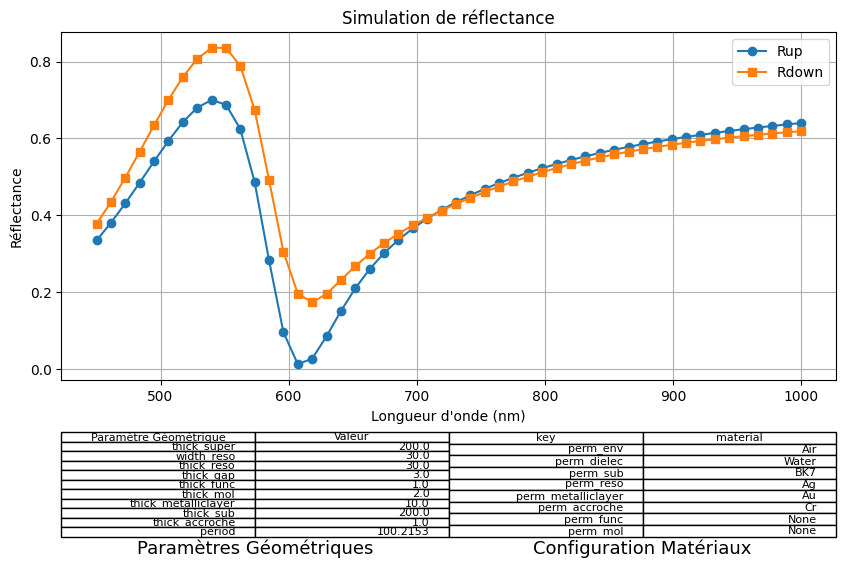

In [10]:
# %% Cellule 5 – Simulation de la réflectance et affichage du résumé
from simulate_reflectance import simulate_reflectance

# Définir la plage de longueurs d'onde et le nombre de modes RCWA
lambda_range = np.linspace(450, 1000, 50)  # en nm
n_mod = 50

if 'MATERIALS_CONFIG' not in globals():
    print("Veuillez d'abord valider la configuration matériaux.")
else:
    # wave et geometry sont définis à partir des paramètres mis à jour
    wave = {"wavelength": lambda_range[0], "angle": 0, "polarization": 1}
    geometry = geometry_config.copy()
    
    # Simulation de la réflectance
    Rup_values, Rdown_values = simulate_reflectance(lambda_range, geometry, wave, MATERIALS_CONFIG, json_path_expdata, n_mod)
    print("Réflectance finale (Rup, Rdown) pour lambda =", lambda_range[-1], ":", Rup_values[-1], Rdown_values[-1])
    
    # Création du plot de la réflectance
    plt.figure(figsize=(10,6))
    plt.plot(lambda_range, Rup_values, 'o-', label='Rup')
    plt.plot(lambda_range, Rdown_values, 's-', label='Rdown')
    plt.xlabel("Longueur d'onde (nm)")
    plt.ylabel("Réflectance")
    plt.legend()
    plt.title("Simulation de réflectance")
    plt.grid(True)
    
    # Préparation d'un tableau pour les paramètres géométriques
    geom_df = pd.DataFrame(list(geometry_config.items()), columns=['Paramètre Géométrique', 'Valeur'])
    # Préparation du tableau pour la configuration matériaux (issus du dropdown)
    mat_df = MATERIALS_CONFIG.copy()  # colonnes: key et material
    
    # Création du tableau récapitulatif avec plt.table (deux tableaux côte à côte)
    cellText_geom = geom_df.values.tolist()
    cellText_mat = mat_df.values.tolist()
    
    # Placer le tableau de la géométrie en bas à gauche
    table_geom = plt.table(cellText=cellText_geom, colLabels=geom_df.columns,
                            loc='bottom', bbox=[0, -0.45, 0.5, 0.3])
    table_geom.auto_set_font_size(False)
    table_geom.set_fontsize(8)
    
    # Placer le tableau de la configuration matériaux en bas à droite
    table_mat = plt.table(cellText=cellText_mat, colLabels=mat_df.columns,
                           loc='bottom', bbox=[0.5, -0.45, 0.5, 0.3])
    table_mat.auto_set_font_size(False)
    table_mat.set_fontsize(8)
    
    # Optionnel : ajouter des titres au-dessus des tableaux
    plt.text(0.25, -0.5, 'Paramètres Géométriques', ha='center', fontsize=13, transform=plt.gca().transAxes)
    plt.text(0.75, -0.5, 'Configuration Matériaux', ha='center', fontsize=13, transform=plt.gca().transAxes)
    
    plt.subplots_adjust(bottom=0.3)
    plt.show()
